In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

In [2]:
dataset = pd.read_csv("../input/nsetataglobal/NSE-TATAGLOBAL11.csv")

FileNotFoundError: [Errno 2] No such file or directory: '../input/nsetataglobal/NSE-TATAGLOBAL11.csv'

There are multiple variables in the dataset – date, open, high, low, last, close, total_trade_quantity, and turnover.
* The columns Open and Close represent the starting and final price at which the stock is traded on a particular day.
* High, Low and Last represent the maximum, minimum, and last price of the share for the day.  
* Total Trade Quantity is the number of shares bought or sold in the day and Turnover (Lacs) is the turnover of the particular company on a given date.


In [4]:
dataset.describe()

,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
count,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1.235000e+03,1235.000000
mean,168.954858,171.429069,166.402308,168.736356,168.731053,2.604151e+06,4843.166502
std,51.499145,52.436761,50.542919,51.587384,51.544928,2.277028e+06,5348.919832
min,103.000000,104.600000,100.000000,102.600000,102.650000,1.001800e+05,128.040000
25%,137.550000,138.925000,135.250000,137.175000,137.225000,1.284482e+06,1801.035000
50%,151.500000,153.250000,149.500000,151.200000,151.100000,1.964885e+06,3068.510000
75%,169.000000,172.325000,166.700000,169.100000,169.500000,3.095788e+06,5852.600000
max,327.700000,328.750000,321.650000,325.950000,325.750000,2.919102e+07,55755.080000


Another important thing is that the market is closed on weekends and public holidays. Notice the above table again, some date values are missing – 2/10/2018, 6/10/2018,
7/10/2018. Of these dates, 2nd is a national holiday while 6th and 7th fall on a weekend.

In [5]:
x = dataset[['High','Low','Open','Total Trade Quantity']].values

In [6]:
y = dataset['Close'].values

The profit or loss calculation is usually determined by the closing price of a stock for the day, hence we considered the closing price as the target variable.

## Using LSTM (Long Short Term Memory) 

LSTMs are widely used for sequence prediction problems and have proven to be extremely effective. The reason they work so well is because LSTM is able to store past information that is important, and forget the information that is not. LSTM has three gates: 
* The input gate: The input gate adds information to the cell state 
* The forget gate: It removes the information that is no longer required by the model 
* The output gate: Output Gate at LSTM selects the information to be shown as output

In [35]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

#creating dataframe
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values

In [36]:
train = dataset[0:960,:]
valid = dataset[960:,:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

#predicting testing values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

2022-10-05 11:46:54.465087: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-10-05 11:46:55.276437: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


900/900 - 19s - loss: 0.0011


In [37]:
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

8.620842332861045

**Root Mean Square Error (RMSE): 8.93**

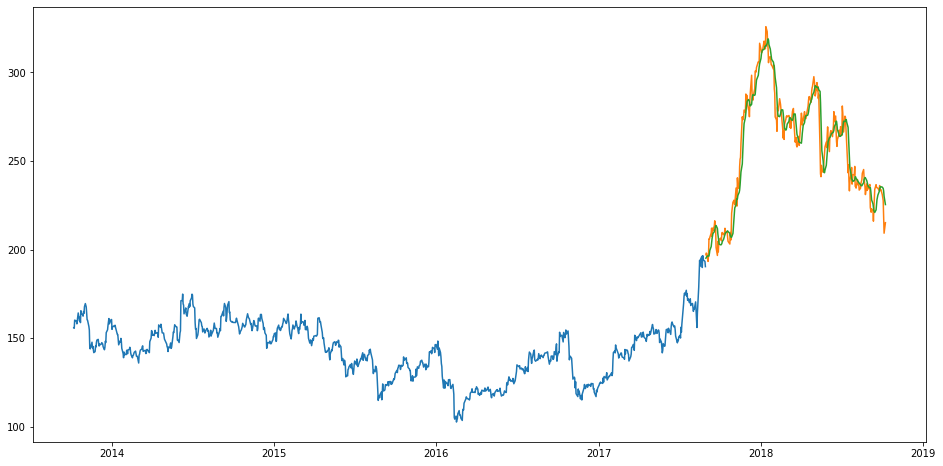

In [38]:
#for plotting
train = new_data[:960]
valid = new_data[960:]
valid['Predictions'] = closing_price

plt.figure(figsize=(16,8))
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])


In [39]:
dframe3 = pd.DataFrame({'Actual':valid['Close'], 'Predicted':valid['Predictions']})

In [40]:
dframe3.head(50)

,Actual,Predicted
Date,,
2017-08-30,197.05,195.112381
2017-08-31,198.0,195.412964
2017-09-01,197.6,195.964401
2017-09-04,193.3,196.501831
2017-09-05,196.7,196.333527
2017-09-06,205.95,196.338394
2017-09-07,205.75,197.743500
2017-09-08,206.9,199.596756
2017-09-11,209.25,201.617645


In [41]:
dframe3.tail(50)

,Actual,Predicted
Date,,
2018-07-24,246.3,239.798248
2018-07-25,236.9,239.549667
2018-07-26,239.1,238.828690
2018-07-27,242.25,238.480331
2018-07-30,242.2,238.868561
2018-07-31,246.9,239.558151
2018-08-01,235.65,241.080612
2018-08-02,235.45,240.973495
2018-08-03,234.65,240.160324


**By comparing RMSE values of all three algorithms, we can say that LSTM performs well in prediction as its RMSE value is very less than that of linear regression and KNN. Also from the above graphs, we can clearly see that LSTM identifies the future trend correctly.**